In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import random
import keras
from matplotlib import pyplot as plt
import numpy as np
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from keras import optimizers
from keras.utils import multi_gpu_model
from keras import backend as K
from SSD_loss import SSDLoss
from importlib import reload
#import cv2
import pet_data
import detection_nets
import tensorflow as tf
from pet_detector_help import *
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
input_H = 224
input_W = 224
input_C = 3
input_shape = (input_H, input_W, input_C)
data_root = "/home/nvidia/dataset/pets/"
extras =  ['S', 512 ]
feature_map = [7,7,4,4,2,1]
aspect_ratios = [[2,3],[2,3],[2,3],[2,3],[2],[2]] 
mbox =  [2 + len(ar) * 2 for ar in aspect_ratios]  # number of boxes per feature map location
source_layers=["out_relu"]

In [3]:
annot = data_root + "annotations"

In [4]:
def generate_class_names(annot):
    list_names = open(annot + '/trainval.txt').readlines()
    class_names = []
    for name in list_names:
        name = name.lower()
        p = name.rfind('_')
        if not name[:p] in class_names:
            class_names.append(name[:p])
    print(class_names)
    file = open(os.path.join(annot,'class_names.txt'),'w')
    file.writelines([name + "\n" for name in class_names ])
generate_class_names(annot)

['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


## Read classnames

In [5]:
#read_class_names(annot):
file = open(os.path.join(annot,'class_names.txt'))
lines = open(os.path.join(annot,'class_names.txt')).readlines()
class_names = [name[:-1] for name in lines]
num_classes = len(class_names)
print(class_names)
print('classes num',num_classes)

['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
classes num 37


## Split annotations

In [6]:
import pet_data
reload(pet_data)
pet_data.split_annotations(data_root,'trainval.txt')

before ignore: 3680
after ignore: 3671


## Load Dataset

In [49]:
(x_train,y_train_no_process),(x_test,y_test_no_process) = pet_data.load_data(0.4,0.25,root=data_root,task = 'detection')
print("x_train shape",x_train.shape," y_train_no_process shape",y_train_no_process.shape)
print("x_test shape",x_test.shape," y_test_no_process shape",y_test_no_process.shape)

...............done
x_train shape (1101, 224, 224, 3)  y_train_no_process shape (1101, 41)
x_test shape (229, 224, 224, 3)  y_test_no_process shape (229, 41)


## Generate prior boxes and process y

In [8]:
y_train = y_train_no_process.copy()
y_test = y_test_no_process.copy()
#print(y_train.shape,y_test.shape)
#print(y_train[:,0])

## Draw a sample of y_true

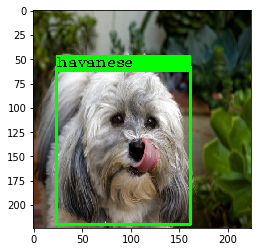

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.108 0.26  0.72  0.985]


In [50]:
import drawing
reload(drawing)
from drawing import *
x = x_train[0].copy()
y = y_train_no_process[0].copy()
#print(y_train_no_process[:,1])
frame= (x * 255).astype('int32')
draw_detection(frame,y,class_names,box_color=(0,255,0),font_scale =0.5,draw_label=True)
plt.imshow(frame)
plt.show()
print(y)

### Load a base model

In [13]:
base_model =  keras.applications.mobilenet_v2.MobileNetV2(input_shape=(input_H,input_W,input_C), alpha=1.0, depth_multiplier=1, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

In [14]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [36]:
def Loss(y_true,y_pred):
    log_loss = -tf.reduce_mean(tf.reduce_sum(y_true[:,:-4] * tf.log(y_pred[:,:-4]), axis=-1))
    mse_loss = tf.reduce_sum(tf.square(y_true[:,-4:] - y_pred[:,-4:]))
    total_loss = log_loss + mse_loss
    return total_loss

### Set hyper params

In [40]:
reload(detection_nets)
base_name = "mobilenetv2"
version_name = "pooling_4000"
source_name ="global_average_pooling2d_1"
build_model = detection_nets.build_simple_detection_net
#Train
phase = 'training' #training or testing
epochs_per_stage = 10
stages = 5
batch_size = 1
verbose = 1
use_data_augment = False
plot = False
#Environment
#clear_session = True
#Learning params
lr=5e-4
decay=1e-6
momentum=0.9
validation_split = 0.25
load_weights = False
check_point = 1
save_path = 'saved_weights'

### Build model with a backbone

In [41]:
#loss = SSDLoss().compute_loss
if phase!='testing' and phase!='training':
    raise RuntimeError("Phase must be either testing or training")
if epochs_per_stage < 1:
    raise RuntimeError("Epochs per stage must be greater than 1")
if stages < 1:
    raise RuntimeError("Stages must be greater than 1")
if phase == 'testing' and load_weights != True:
    print("Warning: phase is testing and load weights is not True")
if phase == 'training' and load_weights == False and check_point != 1:
    print("Warning: Initial check point should be 1")
    check_point = 1
if not os.path.isdir(save_path):
    os.mkdir(save_path)

loss = Loss
model_name,model = build_model(base_model,source_name,num_classes,version_name,base_name)
model.compile(loss=loss,optimizer=optimizers.SGD(lr=lr,decay=decay,momentum=momentum))
#model.summary()
print(model_name,'has been built ')

simple_detection_mobilenetv2_pooling_4000 has been built 


#### Check y train、y_test and output of model should have the same shape

In [42]:
print(model.output.get_shape(),y_train.shape)
assert((np.array(model.output.get_shape().as_list()[1:]) == np.array(y_train.shape[1:])).all())
assert((np.array(model.output.get_shape().as_list()[1:]) == np.array(y_test.shape[1:])).all())

(?, 41) (1101, 41)


## Train or test

In [43]:
if load_weights:
    model.load_weights(save_path + '/' + model_name + '_' + str(check_point) + ".h5")
    print("weights loaded from check point",check_point)
    if phase == 'training':
        check_point += 1
if phase == 'training':
    print('model name',model_name)
    print('start fitting.. ','\nstages:',stages,' epochs_per_stage:',epochs_per_stage,' plot_history:',plot)
    print('learning rate:',lr,' decay:',decay,' momentum:',momentum)
    print('initial checkpoint:',check_point)
    print('load weight:',load_weights)
    for i in range(1,1+stages):
        print("stage ",i,"of",stages)
        history = model.fit(x = x_train, y = y_train, batch_size = 8, epochs = epochs_per_stage, verbose = verbose, validation_split = validation_split)
        #fit_generator(model,x_train,y_train)
        path = save_path + '/' + model_name + '_' + str(check_point) + ".h5"
        print("save at",path)
        model.save_weights(path)
        check_point += 1 
        evaluate(model,x_test,y_test)
        if plot:
            plot_history(history)
elif phase =='testing':
    print('start evaluating')
    result = model.evaluate(x=x_test,y=y_test)
    print('loss',round(result,5))
    evaluate(model,x_test,y_test)
   # model.save_weights(model_name + ".h5")

model name simple_detection_mobilenetv2_pooling_4000
start fitting..  
stages: 5  epochs_per_stage: 10  plot history: False
learning rate: 0.0005  decay: 1e-06  momentum: 0.9
initial checkpoint: 1
load weight: False
stage  1 of 5
Train on 825 samples, validate on 276 samples
Epoch 1/10
825/825 [==============================] - 63s 76ms/step - loss: 3.2664 - val_loss: 2.5837
Epoch 2/10
825/825 [==============================] - 35s 43ms/step - loss: 1.1640 - val_loss: 1.7472
Epoch 3/10
825/825 [==============================] - 35s 43ms/step - loss: 0.6696 - val_loss: 1.3142
Epoch 4/10
825/825 [==============================] - 35s 43ms/step - loss: 0.5082 - val_loss: 1.1328
Epoch 5/10
825/825 [==============================] - 35s 43ms/step - loss: 0.4167 - val_loss: 1.1179
Epoch 6/10
825/825 [==============================] - 35s 43ms/step - loss: 0.3698 - val_loss: 1.0546
Epoch 7/10
825/825 [==============================] - 35s 43ms/step - loss: 0.3466 - val_loss: 0.9520
Epoch 8/10

KeyboardInterrupt: 

In [44]:
result = model.evaluate(x=x_test,y=y_test)
print('loss',round(result,5))
evaluate(model,x_test,y_test)

229/229 [==============================] - 2s 9ms/step
loss 1.37591
class accuracy 0.8428
loc accuracy 0.6201
accuracy  0.5415


*Set hyper params and run all above from here*


#### Select a test image and do the prediction

In [55]:
cats_idx = np.where(y_test[:,0] == 1)[0]
test_idx = [0,1,2,3,4,5,6,7,100,101,102,200,201]
x = x_test
y = y_test
y_pred_no_process = model.predict(x[test_idx])
y_pred = y_pred_no_process.copy()
#print(y_pred)
#y_pred = post_process(y_pred_no_process,priors,iou_thresh=0.01,score_thresh=0.01)
#print(np.where(y_pred_no_process[:,:,1]>0.1))

In [56]:
for k,prediction  in enumerate(y_pred):
    #print(prediction)
    # Extract x from test set
    print("image: ",k)
    frame = (test_set[0][test_idx[k]]*255).astype('int32')
    for c,detections in enumerate(prediction):
        if len(detections) == 0:
            continue
        class_name = class_names[c]
        for detection in detections:
            score = detection[0]
            bbox = detection[1:] * input_H#corner
            print(class_name,score,bbox)
            bbox = bbox.astype('int32')
            draw_detection(frame,bbox,score,class_name,box_width = 3)
    plt.imshow(frame)
    plt.show()

image:  0


NameError: name 'test_set' is not defined

image:  0
(224, 224, 3)
loc pred [0.204 0.019 0.764 0.579]
class pred miniature_pinscher score 0.48047692
loc truth [0.287 0.004 0.623 0.476]
class truth miniature_pinscher score 1.0


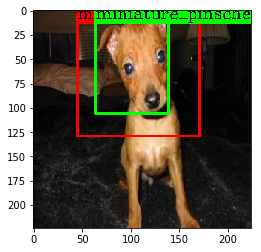

image:  1
(224, 224, 3)
loc pred [0.354 0.113 0.785 0.685]
class pred keeshond score 0.94875866
loc truth [0.354 0.165 0.672 0.73 ]
class truth keeshond score 1.0


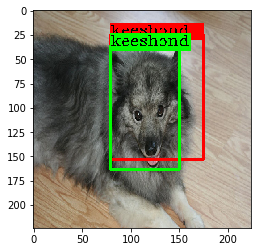

image:  2
(224, 224, 3)
loc pred [0.025 0.009 0.956 0.809]
class pred russian_blue score 0.8429191
loc truth [0.007 0.006 0.904 0.58 ]
class truth russian_blue score 1.0


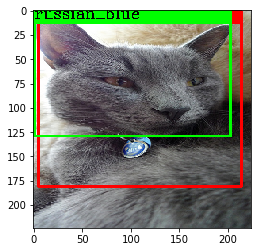

image:  3
(224, 224, 3)
loc pred [0.583 0.366 0.757 0.665]
class pred english_setter score 0.29477778
loc truth [0.548 0.352 0.708 0.627]
class truth english_setter score 1.0


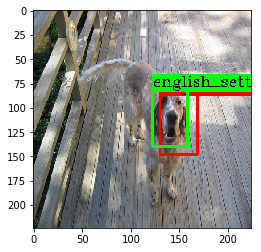

image:  4
(224, 224, 3)
loc pred [0.308 0.03  0.869 0.55 ]
class pred miniature_pinscher score 0.6487419
loc truth [0.34  0.004 0.82  0.44 ]
class truth miniature_pinscher score 1.0


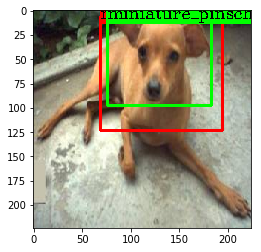

image:  5
(224, 224, 3)
loc pred [0.172 0.083 0.886 0.78 ]
class pred american_pit_bull_terrier score 0.3622327
loc truth [0.176 0.123 0.726 0.82 ]
class truth american_pit_bull_terrier score 1.0


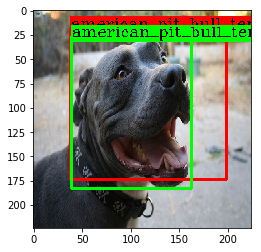

image:  6
(224, 224, 3)
loc pred [0.122 0.032 0.889 0.78 ]
class pred pomeranian score 0.9627155
loc truth [0.178 0.117 0.809 0.67 ]
class truth pomeranian score 1.0


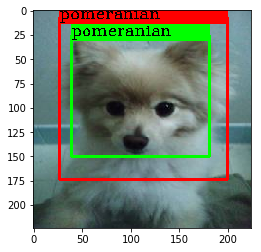

image:  7
(224, 224, 3)
loc pred [0.039 0.01  0.941 0.823]
class pred siamese score 0.96051383
loc truth [0.003 0.002 1.    0.688]
class truth siamese score 1.0


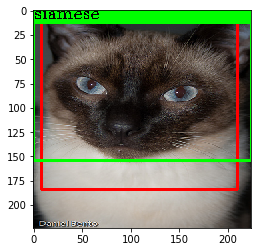

image:  8
(224, 224, 3)
loc pred [0.195 0.093 0.801 0.581]
class pred yorkshire_terrier score 0.9801742
loc truth [0.264 0.177 0.718 0.56 ]
class truth yorkshire_terrier score 1.0


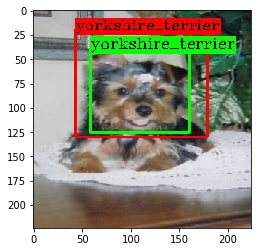

image:  9
(224, 224, 3)
loc pred [0.274 0.144 0.627 0.761]
class pred staffordshire_bull_terrier score 0.9540355
loc truth [0.276 0.275 0.638 0.779]
class truth staffordshire_bull_terrier score 1.0


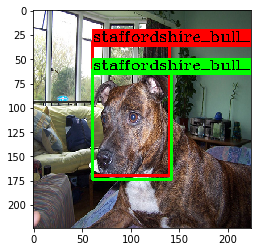

image:  10
(224, 224, 3)
loc pred [0.314 0.29  0.718 0.549]
class pred pug score 0.8455152
loc truth [0.483 0.324 0.733 0.464]
class truth pug score 1.0


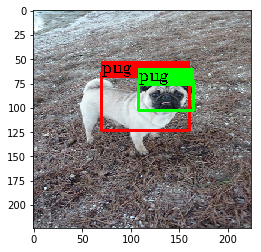

image:  11
(224, 224, 3)
loc pred [0.481 0.136 0.821 0.658]
class pred german_shorthaired score 0.5650791
loc truth [0.598 0.211 0.952 0.533]
class truth german_shorthaired score 1.0


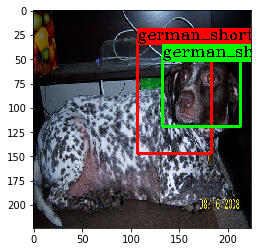

image:  12
(224, 224, 3)
loc pred [0.341 0.208 0.859 0.712]
class pred pug score 0.9746109
loc truth [0.557 0.316 0.887 0.733]
class truth pug score 1.0


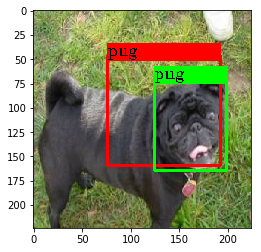

In [60]:
for k,prediction  in enumerate(y_pred):
    #print(prediction)
    # Extract x from test set
    print("image: ",k)
    frame = (x[test_idx[k]] * 255).astype('int32')
    print(frame.shape)
    score = np.max(prediction[:-4])
    spec = np.argmax(prediction[:-4])
    print('loc pred',np.round(prediction[-4:],3))
    print('class pred',class_names[spec],'score',score)
    y_true = y[test_idx[k]]
    spec = np.argmax(y_true[:-4])
    print('loc truth',np.round(y_true[-4:],3))
    print('class truth',class_names[spec])
    draw_detection(frame,prediction,class_names)
    draw_detection(frame,y[test_idx[k]],class_names,box_color = (0,255,0))
    plt.imshow(frame)
    plt.show()

In [47]:
img_file = "data/cat1.png"
img = cv2.imread(img_file)
print(img.shape)
x = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = np.array(x,dtype='float')
x = x / 255
y_pred = model.predict(np.expand_dims(x,0))[0]
print(y_pred)
draw_detection(img,y_pred,class_names,box_width=5,font_scale=1)
plt.imshow(img)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
video_file = "data/cats_video.mp4"
result_file = "res.avi"
cap= cv2.VideoCapture(video_file)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
frames = (int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Input Video Size:',size,' Fps:',fps,' Frames:',frames)
writer = cv2.VideoWriter(result_file,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
success,frame = cap.read()
count = 1
while success:
    x = cv2.resize(frame,dsize=(input_H,input_W),interpolation=cv2.INTER_CUBIC)
    x = x / 255
    y_pred = model.predict(np.expand_dims(x,0))[0]
    draw_detection(frame, y_pred,class_names,font_scale = 1)
    writer.write(frame)
    cv2.waitKey(1)
    count += 1
    if count%50==0:
        plt.imshow(frame)
        plt.show()
        print('.',end='')
    success,frame = cap.read()
print('done')